In [7]:
import os
import h5py
import tkinter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import zscore
from data_import import import_ppd

pre_start = 10
post_start = 20

### Process single PPD file

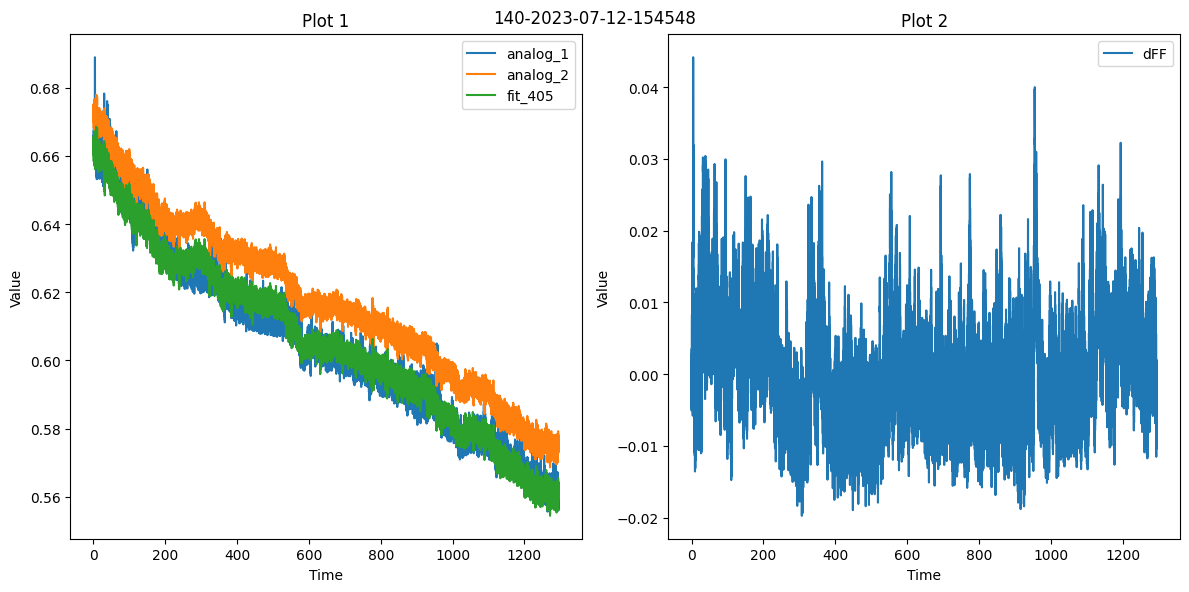

In [8]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\140-2023-07-12-154548.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF
ch1=data['analog_1']
ch2=data['analog_2']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [13]:
data = {
    'UniBe001': {
        'Stim': [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        'Time': ['00:30', '01:28', '01:59', '02:29', '03:23', '03:57', '04:36', '05:24', '06:24', '07:23',
                 '08:10', '08:56', '09:39', '10:13', '10:54', '11:33', '12:15', '13:00', '13:34', '14:11',
                 '15:03', '15:35', '16:09', '16:42', '17:38', '18:09', '18:51', '19:22', '20:00', '20:59']
    }
}

stim_data = data['UniBe001']['Stim']
time_stamps = data['UniBe001']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [0, 1, 3, 8, 9, 10, 14, 17, 18, 21, 22, 23, 26, 27, 29]
Water Time Stamps: ['00:30', '01:28', '02:29', '06:24', '07:23', '08:10', '10:54', '13:00', '13:34', '15:35', '16:09', '16:42', '18:51', '19:22', '20:59']
Water Data Indexes: [3900, 11440, 19370, 49920, 57590, 63700, 85020, 101400, 105820, 121550, 125970, 130260, 147030, 151060, 163670]
TMT Indexes: [2, 4, 5, 6, 7, 11, 12, 13, 15, 16, 19, 20, 24, 25, 28]
TMT Time Stamps: ['01:59', '03:23', '03:57', '04:36', '05:24', '08:56', '09:39', '10:13', '11:33', '12:15', '14:11', '15:03', '17:38', '18:09', '20:00']
TMT Data Indexes: [15470, 26390, 30810, 35880, 42120, 69680, 75270, 79690, 90090, 95550, 110630, 117390, 137540, 141570, 156000]


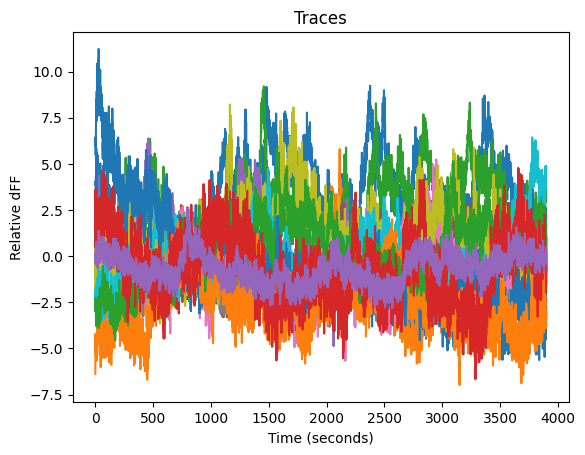

In [33]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    pre_start = 10
    post_start = 20
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline_mean = np.mean(dFF[baseline_start:baseline_end])
    baseline_std = np.std(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    #relative_trace_data = trace_data - baseline
    relative_trace_data = (trace_data - baseline_mean) / baseline_std

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


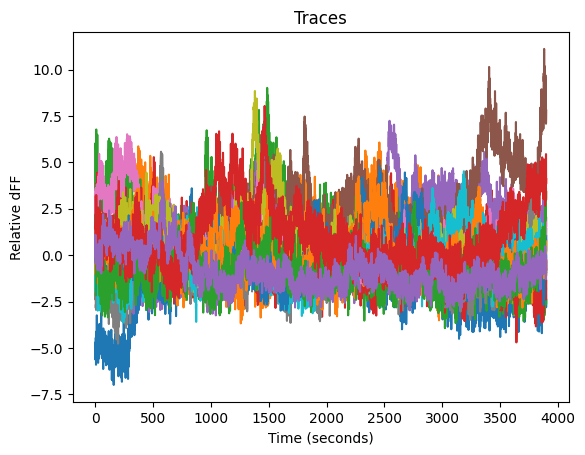

In [34]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline_mean = np.mean(dFF[baseline_start:baseline_end])
    baseline_std = np.std(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    #relative_trace_data = trace_data - baseline
    relative_trace_data = (trace_data - baseline_mean) / baseline_std
    

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


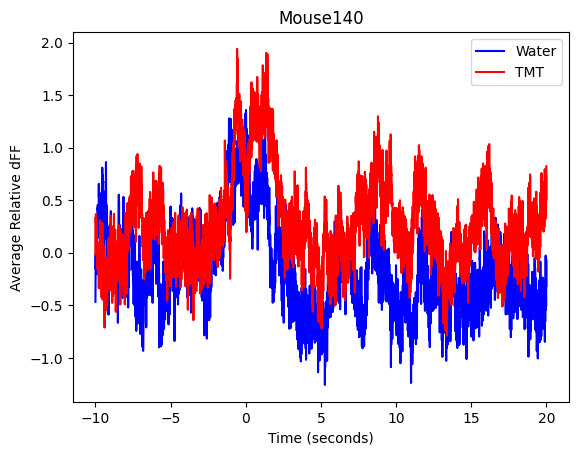

In [35]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse140')
plt.legend()
plt.show()

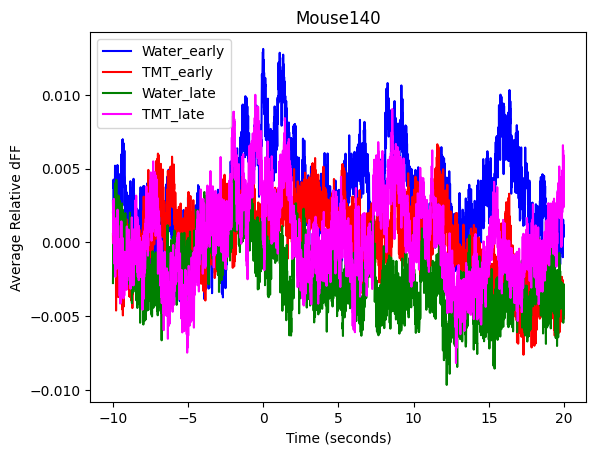

In [29]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse140')
plt.legend()
plt.show()

In [5]:
seeds = ["UniBe{:03d}".format(i) for i in range(1, 14)]

In [6]:
seeds[0]

'UniBe001'

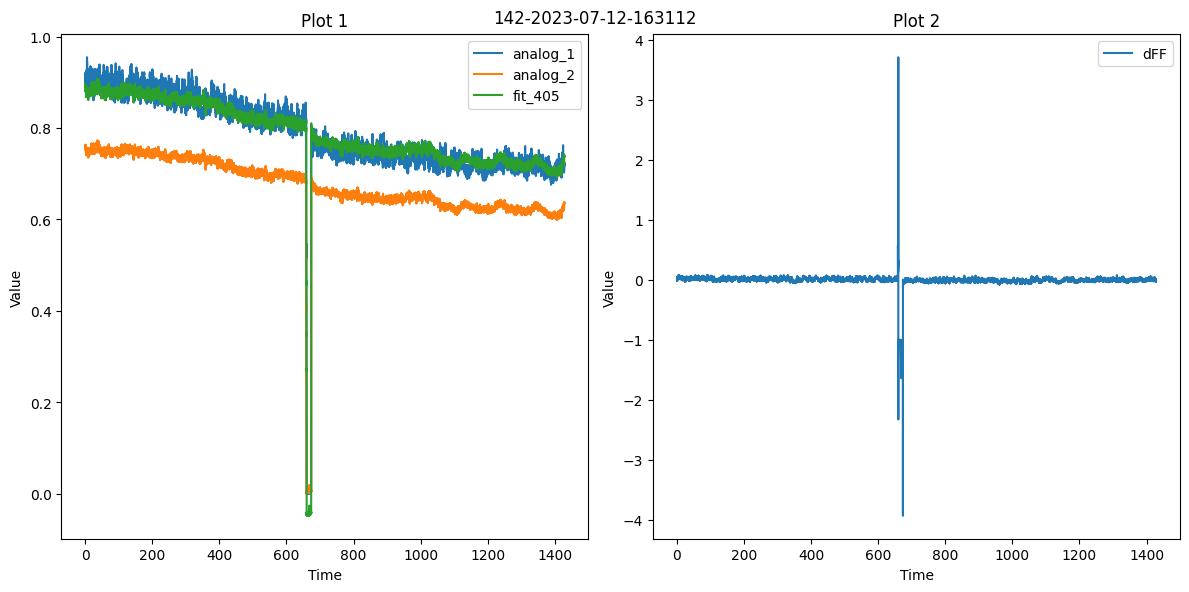

In [13]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\142-2023-07-12-163112.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF
ch1=data['analog_1']
ch2=data['analog_2']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [118]:
data = {
    'UniBe002': 
            {'Stim': [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1], 
             'Time': ['00:30', '01:05', '01:53', '02:25', '03:25', '04:16', '05:10', '05:59', '06:35', '07:19', 
                      '08:17', '08:54', '09:50', '10:36', '11:30', '12:13', '12:48', '13:31', '14:16', '15:15', 
                      '16:08', '17:03', '17:44', '18:27', '19:24', '20:21', '20:53', '21:27', '22:09', '23:07']}
}

stim_data = data['UniBe002']['Stim']
time_stamps = data['UniBe002']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
all_indexes = [i for i, stim in enumerate(stim_data)]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]
all_time_stamps = [time_stamps[i] for i in all_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]
all_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in all_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [0, 1, 5, 6, 10, 13, 15, 16, 17, 20, 21, 22, 24, 25, 27]
Water Time Stamps: ['00:30', '01:05', '04:16', '05:10', '08:17', '10:36', '12:13', '12:48', '13:31', '16:08', '17:03', '17:44', '19:24', '20:21', '21:27']
Water Data Indexes: [3900, 8450, 33280, 40300, 64610, 82680, 95290, 99840, 105430, 125840, 132990, 138320, 151320, 158730, 167310]
TMT Indexes: [2, 3, 4, 7, 8, 9, 11, 12, 14, 18, 19, 23, 26, 28, 29]
TMT Time Stamps: ['01:53', '02:25', '03:25', '05:59', '06:35', '07:19', '08:54', '09:50', '11:30', '14:16', '15:15', '18:27', '20:53', '22:09', '23:07']
TMT Data Indexes: [14690, 18850, 26650, 46670, 51350, 57070, 69420, 76700, 89700, 111280, 118950, 143910, 162890, 172770, 180310]


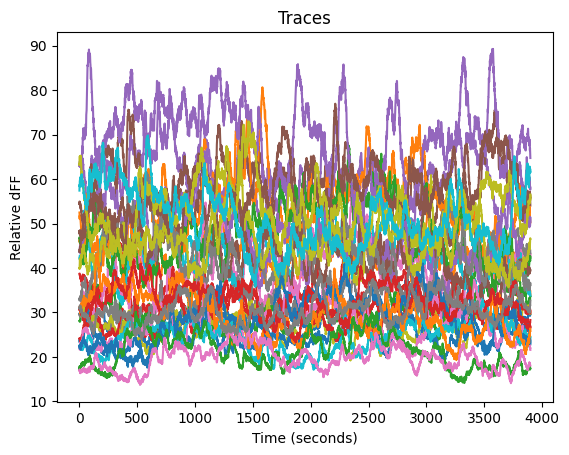

In [144]:

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in all_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = ch1[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline_mean = np.mean(ch2[baseline_start:baseline_end])
    baseline_std = np.std(ch2[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = (trace_data - baseline_mean) / baseline_std

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix = np.array(trace_data_matrix)
trace_data_matrix_water = trace_data_matrix[water_indexes]
trace_data_matrix_tmt = trace_data_matrix[tmt_indexes]

#from scipy.stats import zscore

#trace_data_matrix_water = zscore(trace_data_matrix_water, axis=1)

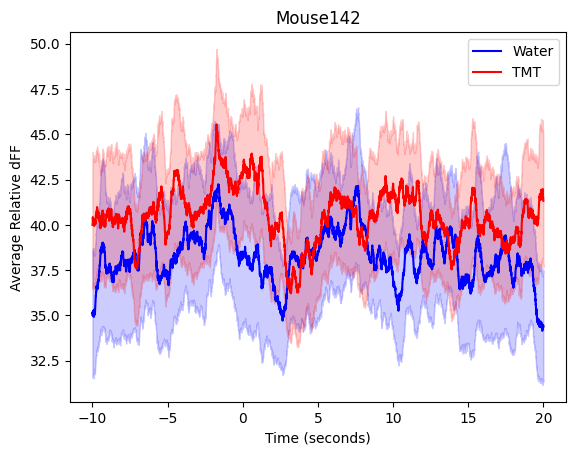

In [147]:
# Calculate SEM for water and TMT
sem_water = np.std(trace_data_matrix_water, axis=0) / np.sqrt(trace_data_matrix_water.shape[0])
sem_tmt = np.std(trace_data_matrix_tmt, axis=0) / np.sqrt(trace_data_matrix_tmt.shape[0])

# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

# Time array
time_array = np.arange(-pre_start, post_start, 1/sampling_rate)

plt.plot(time_array, average_trace_water, label='Water', color='blue')
plt.fill_between(time_array, average_trace_water - sem_water, average_trace_water + sem_water, color='blue', alpha=0.2)

plt.plot(time_array, average_trace_tmt, label='TMT', color='red')
plt.fill_between(time_array, average_trace_tmt - sem_tmt, average_trace_tmt + sem_tmt, color='red', alpha=0.2)

plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse142')
plt.legend()
plt.show()


In [148]:
trace_data_matrix_water.shape



(15, 3900)

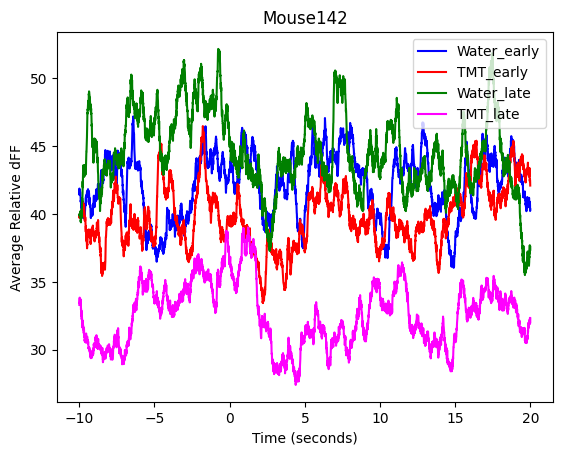

In [149]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse142')
plt.legend()
plt.show()

### Process single PPD file

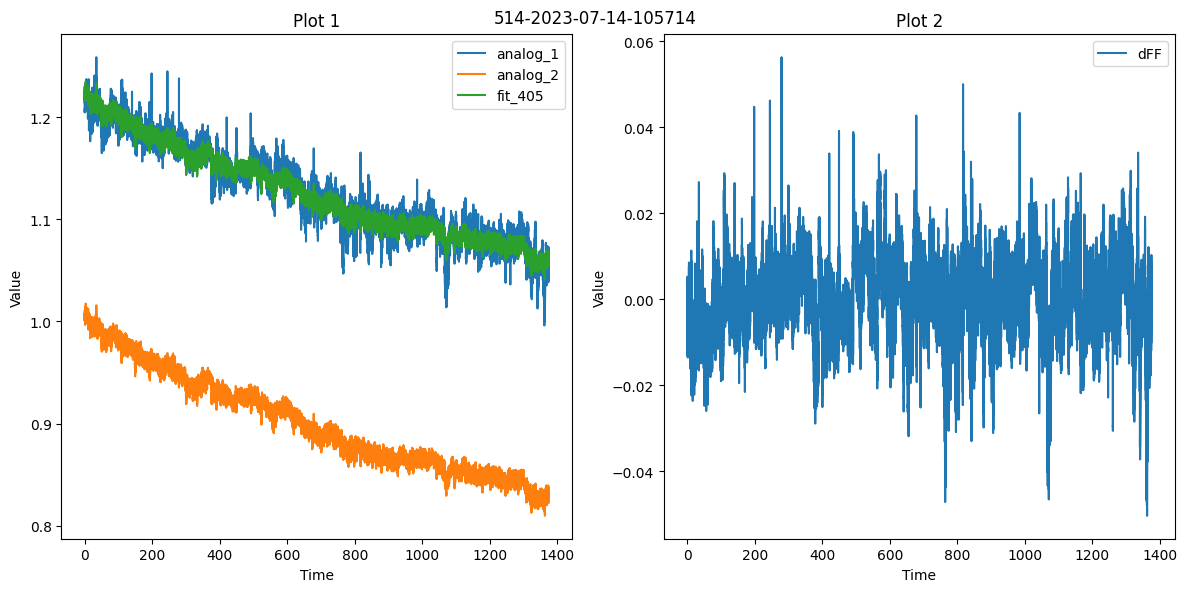

In [19]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\514-2023-07-14-105714.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
ch1=data['analog_1']
ch2=data['analog_2']
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [20]:
data = {
    'UniBe003': 
            {'Stim': [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], 
             'Time': ['00:30', '01:17', '01:47', '02:28', '03:11', '03:43', '04:19', '04:59', '05:32', '06:29', 
                      '07:28', '08:11', '08:42', '09:23', '10:18', '11:13', '12:04', '13:00', '13:36', '14:22', 
                      '15:13', '16:11', '16:52', '17:40', '18:14', '18:47', '19:36', '20:32', '21:22', '22:13']}
}

stim_data = data['UniBe003']['Stim']
time_stamps = data['UniBe003']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [0, 1, 3, 4, 5, 6, 8, 10, 12, 16, 17, 20, 23, 26, 29]
Water Time Stamps: ['00:30', '01:17', '02:28', '03:11', '03:43', '04:19', '05:32', '07:28', '08:42', '12:04', '13:00', '15:13', '17:40', '19:36', '22:13']
Water Data Indexes: [3900, 10010, 19240, 24830, 28990, 33670, 43160, 58240, 67860, 94120, 101400, 118690, 137800, 152880, 173290]
TMT Indexes: [2, 7, 9, 11, 13, 14, 15, 18, 19, 21, 22, 24, 25, 27, 28]
TMT Time Stamps: ['01:47', '04:59', '06:29', '08:11', '09:23', '10:18', '11:13', '13:36', '14:22', '16:11', '16:52', '18:14', '18:47', '20:32', '21:22']
TMT Data Indexes: [13910, 38870, 50570, 63830, 73190, 80340, 87490, 106080, 112060, 126230, 131560, 142220, 146510, 160160, 166660]


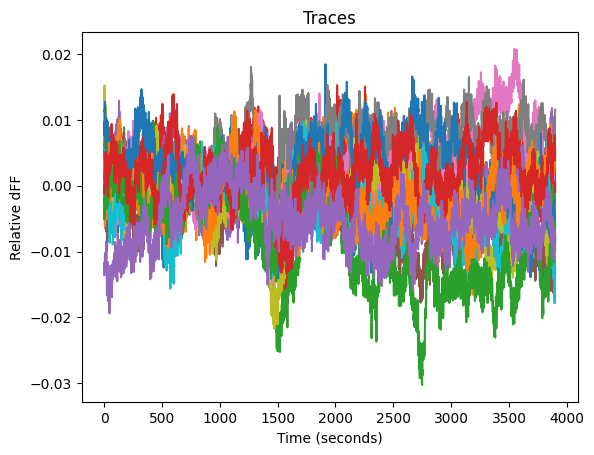

In [29]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = ch2[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(ch2[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


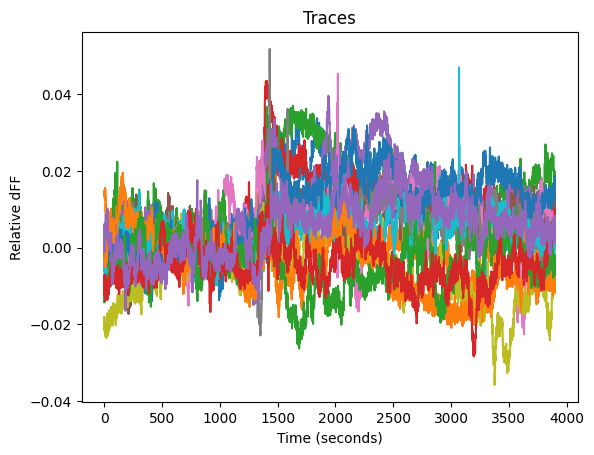

In [30]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


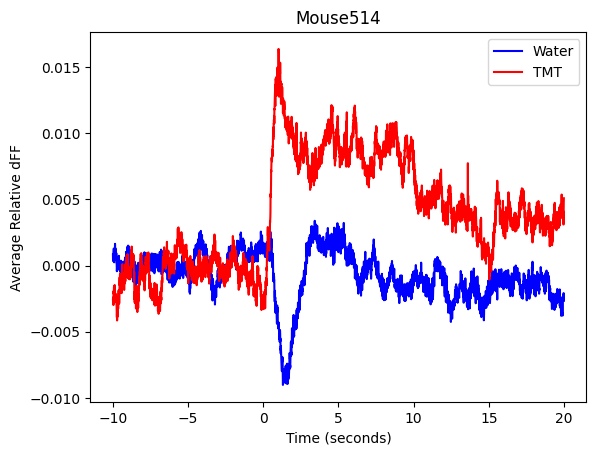

In [31]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse514')
plt.legend()
plt.show()

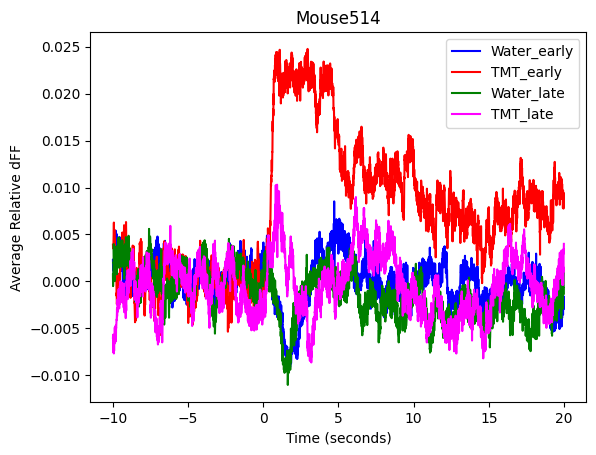

In [32]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse514')
plt.legend()
plt.show()

In [36]:
data = {
        'UniBe001': 
            {'Stim': [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0], 
             'Time': ['00:29', '01:27', '01:58', '02:28', '03:22', '03:56', '04:35', '05:23', '06:23', '07:22', 
                      '08:09', '08:55', '09:38', '10:12', '10:53', '11:32', '12:14', '12:59', '13:33', '14:10', 
                      '15:02', '15:34', '16:08', '16:41', '17:37', '18:08', '18:50', '19:21', '19:59', '20:58']}, 
        'UniBe002': 
            {'Stim': [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1], 
             'Time': ['00:28', '01:03', '01:51', '02:23', '03:23', '04:14', '05:08', '05:57', '06:33', '07:17', 
                      '08:15', '08:52', '09:48', '10:34', '11:28', '12:11', '12:46', '13:29', '14:14', '15:13', 
                      '16:06', '17:01', '17:42', '18:25', '19:22', '20:19', '20:51', '21:25', '22:07', '23:05']}, 
        'UniBe003': 
            {
            'Stim': [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], 
            'Time': ['00:29', '01:16', '01:46', '02:27', '03:10', '03:42', '04:18', '04:58', '05:31', '06:28', 
                     '07:27', '08:10', '08:41', '09:22', '10:17', '11:12', '12:03', '12:59', '13:35', '14:21', 
                     '15:12', '16:10', '16:51', '17:39', '18:13', '18:46', '19:35', '20:31', '21:21', '22:12']}, 

        'UniBe004': 
            {'Stim': [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0], 
             'Time': ['00:30', '01:29', '02:07', '02:48', '03:39', '04:19', '04:59', '05:46', '06:20', '06:50', 
                      '07:49', '08:38', '09:37', '10:19', '11:16', '12:03', '12:42', '13:34', '14:08', '14:53', 
                      '15:25', '16:12', '16:56', '17:41', '18:11', '19:06', '19:43', '20:27', '21:02', '22:02']}, 
        'UniBe005': 
            {'Stim': [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0] ,
            'Time': ['00:30', '01:25', '02:24', '03:12', '03:45', '04:17', '04:52', '05:38', '06:09', '06:44', 
                    '07:30', '08:17', '08:49', '09:42', '10:31', '11:30', '12:26', '13:23', '14:11', '15:08', 
                    '15:57', '16:30', '17:10', '18:06', '18:39', '19:33', '20:25', '21:21', '22:01', '22:34'] }, 
        'UniBe006': 
            {'Stim': [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1], 
             'Time': ['00:30', '01:26', '02:22', '03:00', '03:46', '04:45', '05:44', '06:16', '06:47', '07:19', 
                    '08:07', '08:53', '09:39', '10:30', '11:21', '12:06', '12:38', '13:16', '14:08', '14:57', 
                    '15:48', '16:40', '17:26', '18:04', '18:56', '19:49', '20:29', '21:22', '22:22', '23:17']}, 
        'UniBe007': 
            {'Stim': [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
             'Time': ['00:30', '01:09', '01:42', '02:21', '03:15', '04:06', '05:03', '05:47', '06:17', '07:13', 
                    '08:02', '08:32', '09:05', '09:44', '10:25', '11:03', '11:45', '12:18', '12:54', '13:44',
                    '14:34', '15:05', '15:39', '16:14', '17:02', '17:37', '18:34', '19:14', '19:58', '20:52']}, 
        'UniBe008': {
            'Stim': [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
            'Time': ['00:33', '01:14', '01:55', '02:44', '03:23', '04:22', '05:10', '06:02', '06:55', '07:39', 
                    '08:34', '09:17', '10:08', '10:51', '11:45', '12:44', '13:28', '14:05', '15:00', '15:50', 
                    '16:35', '17:24', '18:09', '19:03', '19:39', '20:30', '21:06', '21:55', '22:31', '23:18']},

        'UniBe009': 
            {
            'Stim': [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
            'Time': ['00:29', '01:23', '02:10', '03:00', '03:56', '04:34', '05:22', '06:06', '07:00', '07:41',
                     '08:20', '08:53', '09:44', '10:20', '11:20', '11:55', '12:41', '13:41', '14:19', '15:01',
                     '15:48', '16:26', '17:15', '17:48', '18:31', '19:27', '20:16', '20:50', '21:20', '22:13']}, 

        'UniBe010': 
            {'Stim': [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
            'Time': ['00:29', '01:27', '02:07', '02:42', '03:27', '03:58', '04:32', '05:31', '06:10', '06:53',
                     '07:38', '08:24', '09:00', '09:50', '10:47', '11:42', '12:24', '13:08', '13:54', '14:53',
                     '15:35', '16:25', '17:13', '18:03', '18:34', '19:04', '19:51', '20:47', '21:18', '21:58']}, 

        'UniBe011': 
            {'Stim': [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1], 
            'Time': ['00:29', '01:05', '01:42', '02:18', '03:12', '03:45', '04:45', '05:19', '06:01', '06:42', 
             '07:27', '08:27', '09:20', '10:12', '11:11', '12:00', '12:59', '13:33', '14:10', '14:47', 
             '15:25', '16:02', '16:50', '17:45', '18:37', '19:29', '20:26', '21:20', '22:08', '22:57']}, 

        'UniBe012': 
            {'Stim': [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1], 
             'Time': ['00:30', '01:02', '01:47', '02:39', '03:22', '04:17', '05:04', '05:52', '06:39', '07:12', 
                    '07:42', '08:14', '09:14', '10:03', '10:39', '11:23', '12:15', '12:56', '13:52', '14:31', 
                    '15:07', '15:42', '16:37', '17:17', '18:15', '19:09', '20:08', '20:39', '21:19', '22:12']}, 

        'UniBe013': 
            {'Stim': [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,], 
             'Time': ['00:30', '01:06', '01:49', '02:29', '03:04', '04:01', '04:40', '05:25', '06:12', '06:48',
                     '07:34', '08:31', '09:10', '09:52', '10:43', '11:24', '12:00', '12:41', '13:13', '13:58', 
                     '14:53', '15:29', '17:06', '17:48', '18:23', '18:57', '19:56', '20:46', '21:18', '22:00']}}

In [39]:
import numpy as np

# Define a function to convert time strings into seconds
def time_to_seconds(time_string):
    minutes, seconds = map(int, time_string.split(':'))
    return minutes * 60 + seconds * 1

# Initialize empty lists for the two matrices
stim_type = []
stim_time = []

# Iterate over the provided data
for key in data:
    # Convert the 'Stim' list into a numpy array and append it to the 'stim_type' list
    stim_type.append(np.array(data[key]['Stim']))
    # Convert the 'Time' list into seconds and append it to the 'stim_time' list
    stim_time.append(np.array([time_to_seconds(t) for t in data[key]['Time']]))

# Convert the lists into numpy arrays
stim_type = np.array(stim_type)
stim_time = np.array(stim_time)

stim_type.shape, stim_time.shape, stim_type, stim_time


((13, 30),
 (13, 30),
 array([[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
         0, 0, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
         0, 1, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
         0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
         1, 0, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
         0, 1, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 0, 1, 1, 1, 0